# **Сравнение моделей МО различной архитектуры** (по реальным данным климатической модели ИВМ РАН версии INM-CM6P).

In [13]:
# импортируем все необходимые библиотеки
import os
import lime
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import lime.lime_tabular
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

#### Создаем массив со **всеми** интересующими нас метеопараметрами

In [2]:
path = 'C:/Users/1/Desktop/Dissertation/INMCM6P_data/historical'

file1 = 'SST_1960_2024.nc'
ds1 = xr.open_dataset(os.path.join(path,file1))
print(ds1['SST'].attrs)
ds1['SST'] = ds1['SST'] - 273.15 # переводим значения ТПО из градусов Кельвина в градусы Цельсия
ds1['SST'].attrs['units'] = 'C'
print(ds1['SST'].attrs)
ds1 = ds1.isel(time=slice(0, 660)) # вырезаем период 1960-2014 гг.

file2 = 'T2_1960_2024.nc' 
ds2 = xr.open_dataset(os.path.join(path, file2))
print(ds2['T2'].attrs)
ds2['T2'] = ds2['T2'] - 273.15 # переводим значения T2 из градусов Кельвина в градусы Цельсия
ds2['T2'].attrs['units'] = 'C'
print(ds2['T2'].attrs)
ds2 = ds2.isel(time=slice(0, 660)) # вырезаем период 1960-2014 гг.

file3 = 'PREC_1960_2024.nc' 
ds3 = xr.open_dataset(os.path.join(path, file3))
print(ds3['PREC'].attrs)
days_in_month = ds3.time.dt.days_in_month # количество дней в каждом месяце
ds3['PREC'] = ds3['PREC'] * days_in_month # переводим значения осадков из мм/сут в мм/мес
ds3['PREC'].attrs['units'] = 'mm/mon'
print(ds3['PREC'].attrs)
ds3 = ds3.isel(time=slice(0, 660)) # вырезаем период 1960-2014 гг.

file4 = 'PS_1960_2024.nc' 
ds4 = xr.open_dataset(os.path.join(path, file4))
print(ds4['PS'].attrs)
ds4['PS'].attrs['units'] = 'hPa' # переводим значения давления из Па в гПа (в исходном файле указаны неправильные единицы измерения)
print(ds4['PS'].attrs)
ds4 = ds4.isel(time=slice(0, 660)) # вырезаем период 1960-2014 гг.

print(f'Метеовеличина в ds1 (SST): {list(ds1.data_vars)}')
print(f'Размерность ТПО: {ds1['SST'].shape}')
print(f'Метеовеличина в ds2 (T2): {list(ds2.data_vars)}')
print(f'Метеовеличина в ds3 (PREC): {list(ds3.data_vars)}')
print(f'Метеовеличина в ds4 (PS): {list(ds4.data_vars)}')

{'units': 'K', 'standard_name': 'sea surfase temperature'}
{'units': 'C'}
{'units': 'K', 'standard_name': '2m temperature'}
{'units': 'C'}
{'units': 'mm/day(?)', 'standard_name': 'precipitation'}
{'units': 'mm/mon'}
{'units': 'Pa', 'standard_name': 'sea level pressure'}
{'units': 'hPa', 'standard_name': 'sea level pressure'}
Метеовеличина в ds1 (SST): ['SST']
Размерность ТПО: (660, 120, 180)
Метеовеличина в ds2 (T2): ['T2']
Метеовеличина в ds3 (PREC): ['PREC']
Метеовеличина в ds4 (PS): ['PS']


#### Преобразуем данные в **глобально осредненные** (*больше не будем рассматривать 1 точку*) и генерируем **новые признаки** - среднемесячные и среднегодовые **аномалии** (*для всех метеополей*)

In [3]:
weights = np.cos(np.deg2rad(ds1.lat))
weights.name = "weights" # агрегируем данные по всему земному шару с учетом площади ячеек (косинус широты)

weighted_mean_sst = ds1['SST'].weighted(weights).mean(dim=['lat', 'lon'])
print(f'Размерность агрегированной ТПО: {weighted_mean_sst.shape}')

weighted_mean_t2 = ds2['T2'].weighted(weights).mean(dim=['lat', 'lon'])

weighted_mean_prec = ds3['PREC'].weighted(weights).mean(dim=['lat', 'lon'])

weighted_mean_ps = ds4['PS'].weighted(weights).mean(dim=['lat', 'lon'])

sst_mon = ds1['SST'].sel(
    time=slice('1971-01', '2000-12')
).groupby('time.month').mean(dim='time')
print(f'Размерность среднемесячной климатической нормы ТПО: {sst_mon.shape}')
sst_man = ds1['SST'].groupby('time.month') - sst_mon
weighted_mean_sst_man = sst_man.weighted(weights).mean(dim=['lat', 'lon'])

sst_yea = ds1['SST'].sel(
    time=slice('1971-01', '2000-12')
).mean(dim='time')
print(f'Размерность среднегодовой климатической нормы ТПО: {sst_yea.shape}')
sst_yan = ds1['SST'] - sst_yea
weighted_mean_sst_yan = sst_yan.weighted(weights).mean(dim=['lat', 'lon'])

t2_mon = ds2['T2'].sel(
    time=slice('1971-01', '2000-12')
).groupby('time.month').mean(dim='time')
t2_man = ds2['T2'].groupby('time.month') - t2_mon
weighted_mean_t2_man = t2_man.weighted(weights).mean(dim=['lat', 'lon'])

t2_yea = ds2['T2'].sel(
    time=slice('1971-01', '2000-12')
).mean(dim='time')
t2_yan = ds2['T2'] - t2_yea
weighted_mean_t2_yan = t2_yan.weighted(weights).mean(dim=['lat', 'lon'])

prec_mon = ds3['PREC'].sel(
    time=slice('1971-01', '2000-12')
).groupby('time.month').mean(dim='time')
prec_man = ds3['PREC'].groupby('time.month') - prec_mon
weighted_mean_prec_man = prec_man.weighted(weights).mean(dim=['lat', 'lon'])

prec_yea = ds3['PREC'].sel(
    time=slice('1971-01', '2000-12')
).mean(dim='time')
prec_yan = ds3['PREC'] - prec_yea
weighted_mean_prec_yan = prec_yan.weighted(weights).mean(dim=['lat', 'lon'])

ps_mon = ds4['PS'].sel(
    time=slice('1971-01', '2000-12')
).groupby('time.month').mean(dim='time')
ps_man = ds4['PS'].groupby('time.month') - ps_mon
weighted_mean_ps_man = ps_man.weighted(weights).mean(dim=['lat', 'lon'])

ps_yea = ds4['PS'].sel(
    time=slice('1971-01', '2000-12')
).mean(dim='time')
ps_yan = ds4['PS'] - ps_yea
weighted_mean_ps_yan = ps_yan.weighted(weights).mean(dim=['lat', 'lon'])

df = pd.DataFrame({
    'SST': weighted_mean_sst.values,
    'SST_mon_anom': weighted_mean_sst_man.values,
    'SST_yea_anom': weighted_mean_sst_yan.values,
    'T2': weighted_mean_t2.values,
    'T2_mon_anom': weighted_mean_t2_man.values,
    'T2_yea_anom': weighted_mean_t2_yan.values,
    'PREC': weighted_mean_prec.values,
    'PREC_mon_anom': weighted_mean_prec_man.values,
    'PREC_yea_anom': weighted_mean_prec_yan.values,
    'PS': weighted_mean_ps.values,
    'PS_mon_anom': weighted_mean_ps_man.values,
    'PS_yea_anom': weighted_mean_ps_yan.values,
}, index=weighted_mean_sst.time.values)
df.index = pd.to_datetime(df.index).to_period('M')
df.index.name = 'time'

print(f'Размер датайфрема: {df.shape}') 
print(f'Временной период: {df.index.min()} - {df.index.max()}')

display(df) # выводим датайфрем
display(df.info()) # выводим информацию о нем
display(df.describe()) # выводим основные стат. характеристики

df = df.apply(pd.to_numeric, errors='coerce') # преобразуем текстовые значения в числовые
df.to_csv('C:/Users/1/Desktop/МО в гидрометеорологии/Task5/INMCM6P_1960_2024.csv', index = True) # сохраняем результаты в csv-файл

Размерность агрегированной ТПО: (660,)
Размерность среднемесячной климатической нормы ТПО: (12, 120, 180)
Размерность среднегодовой климатической нормы ТПО: (120, 180)
Размер датайфрема: (660, 12)
Временной период: 1960-01 - 2014-12


,SST,SST_mon_anom,SST_yea_anom,T2,T2_mon_anom,T2_yea_anom,PREC,PREC_mon_anom,PREC_yea_anom,PS,PS_mon_anom,PS_yea_anom
time,,,,,,,,,,,,
1960-01,16.783693,-0.111349,-0.242759,11.705927,-0.289997,-2.073320,94.826917,0.388390,2.370949,1011.335409,-0.003692,0.309467
1960-02,16.944997,-0.024850,-0.081455,12.063265,-0.113100,-1.715982,89.817285,3.904304,-2.638682,1011.455536,0.053535,0.429594
1960-03,17.075252,-0.003250,0.048801,12.653462,-0.088331,-1.125785,93.795011,-0.507500,1.339044,1011.386341,0.048901,0.360399
1960-04,17.221201,-0.026034,0.194750,13.646185,-0.075777,-0.133062,92.873242,1.223651,0.417274,1011.149232,-0.006927,0.123290
1960-05,17.248982,-0.077917,0.222530,14.585307,-0.143191,0.806060,96.633063,1.300371,4.177096,1010.946216,0.034560,-0.079727
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08,17.401367,0.416601,0.374915,16.073286,0.548087,2.294039,95.666253,1.056586,3.210286,1010.565106,-0.071064,-0.460836
2014-09,17.396201,0.458173,0.369750,15.388779,0.623882,1.609532,89.732031,0.744954,-2.723937,1010.705704,-0.082801,-0.320238
2014-10,17.404741,0.513172,0.378290,14.133744,0.478375,0.354497,92.516884,1.897762,0.060917,1010.952422,-0.063193,-0.073520


<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 660 entries, 1960-01 to 2014-12
Freq: M
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SST            660 non-null    float64
 1   SST_mon_anom   660 non-null    float64
 2   SST_yea_anom   660 non-null    float64
 3   T2             660 non-null    float64
 4   T2_mon_anom    660 non-null    float64
 5   T2_yea_anom    660 non-null    float64
 6   PREC           660 non-null    float64
 7   PREC_mon_anom  660 non-null    float64
 8   PREC_yea_anom  660 non-null    float64
 9   PS             660 non-null    float64
 10  PS_mon_anom    660 non-null    float64
 11  PS_yea_anom    660 non-null    float64
dtypes: float64(12)
memory usage: 67.0 KB


None

,SST,SST_mon_anom,SST_yea_anom,T2,T2_mon_anom,T2_yea_anom,PREC,PREC_mon_anom,PREC_yea_anom,PS,PS_mon_anom,PS_yea_anom
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,17.099538,0.073087,0.073087,13.872890,0.093642,0.093642,92.746718,0.290751,0.290751,1011.014222,-0.011720,-0.011720
std,0.300802,0.260254,0.300802,1.387747,0.330026,1.387747,3.295424,1.193855,3.295424,0.281239,0.056561,0.281239
min,16.475381,-0.390855,-0.551070,11.611958,-0.515104,-2.167289,83.563442,-2.929465,-8.892525,1010.499818,-0.161587,-0.526124
25%,16.853326,-0.160011,-0.173125,12.578958,-0.200234,-1.200290,90.300791,-0.525947,-2.155177,1010.746763,-0.051234,-0.279179
50%,17.088243,0.031543,0.061792,13.714007,0.027129,-0.065241,93.495593,0.225598,1.039626,1011.054381,-0.011898,0.028438
75%,17.323727,0.327951,0.297275,15.227663,0.411208,1.448416,95.194036,1.081695,2.738069,1011.266317,0.029953,0.240375
max,17.849027,0.649963,0.822576,16.394928,0.826346,2.615681,99.348874,3.947736,6.892906,1011.513364,0.174332,0.487422


#### Генерируем **новые признаки** (*время* - **год**, **сезон** и **месяц**)

In [5]:
df['year'] = df.index.year
df['month'] = df.index.month
seasons_names = {
    'DJF': [12, 1, 2],
    'MAM': [3, 4, 5],
    'JJA': [6, 7, 8],
    'SON': [9, 10, 11]}
month_to_season = {} # создаем словарь месяц - сезон
for season, months in seasons_names.items():
    for month in months:
        month_to_season[month] = season
df['season'] = df['month'].map(month_to_season)
season_numbers = {'DJF': 0, 'MAM': 1, 'JJA': 2, 'SON': 3}
df['seas_num'] = df['season'].map(season_numbers)

#### **Масштабируем** признаки и целевую переменную с помощью **скейлера StandardScaler** и **обучаем** 10 **моделей** для их дальнейшего сравнения

In [6]:
models = [DecisionTreeRegressor(),
          GaussianProcessRegressor(),
          GradientBoostingRegressor(),
          HistGradientBoostingRegressor(),
          KNeighborsRegressor(),
          LinearRegression(), 
          MLPRegressor(),
          RandomForestRegressor(),
          Ridge(),
          SVR()] 

tscv = TimeSeriesSplit(n_splits=4, test_size = 132)

scores = {'R2': 'r2',
    'neg_rmse': 'neg_root_mean_squared_error',
    'neg_mae': 'neg_mean_absolute_error'}

target = 'SST_mon_anom'
features = ['T2', 'T2_mon_anom', 
            'PREC', 'PREC_mon_anom', 
            'PS', 'PS_mon_anom']

df_ = df.copy()
df_Xy = df_.dropna()

y = df_Xy[target] # целевая переменная - ТПО
display(y)
X = df_Xy.drop(columns=['SST', 'SST_mon_anom', 'SST_yea_anom', 
                        'year', 'month', 
                        'season', 'seas_num']) 
# признаковое описание - Т2 и ее аномалии, осадки и их аномалии, ДУМ и его аномалии
display(X)

X_array = X.values # преобразуем из pandas в NumPy 
y_array = y.values # преобразуем из pandas в NumPy

cv_results_sc = {}

for mod in tqdm(models, desc='Модели с маштабированием'):
    mod_name = mod.__class__.__name__
    cv_results_sc[mod_name] = {}
    model = Pipeline([
                    ('scaler', StandardScaler(with_mean=True, with_std=True)),
                    ('regressor', TransformedTargetRegressor(regressor=mod, transformer=StandardScaler(with_mean=True, with_std=True)))
                    ])
    scoring_sc = cross_validate(model, X_array, y_array, cv=tscv, scoring=scores,
                            return_train_score = True, n_jobs=-1, return_estimator=True, return_indices=True)
    scoring_sc['train_idx'] = scoring_sc['indices']['train']
    scoring_sc['test_idx'] = scoring_sc['indices']['test']
    scoring_sc.pop('indices')
    
    scoring_sc['model'] = mod_name
    cv_results_sc[mod_name] = scoring_sc

scores_df_sc = pd.concat([pd.DataFrame(cv_results_sc[mod]) for mod in cv_results_sc.keys()], ignore_index=True)
scores_df_sc['test_rmse'] = -scores_df_sc['test_neg_rmse']
scores_df_sc['train_rmse'] = -scores_df_sc['train_neg_rmse']
scores_df_sc['test_mae'] = -scores_df_sc['test_neg_mae']
scores_df_sc['train_mae'] = -scores_df_sc['train_neg_mae']
scores_df_sc = scores_df_sc.drop(columns=['test_neg_rmse', 'train_neg_rmse', 'test_neg_mae', 'train_neg_mae'])
print(f'Размер итогового DataFrame: {scores_df_sc.shape}')
print(f'Уникальные модели: {scores_df_sc['model'].nunique()}')
scores_df_sc.head()

time
1960-01   -0.111349
1960-02   -0.024850
1960-03   -0.003250
1960-04   -0.026034
1960-05   -0.077917
             ...   
2014-08    0.416601
2014-09    0.458173
2014-10    0.513172
2014-11    0.508686
2014-12    0.445220
Freq: M, Name: SST_mon_anom, Length: 660, dtype: float64

,T2,T2_mon_anom,T2_yea_anom,PREC,PREC_mon_anom,PREC_yea_anom,PS,PS_mon_anom,PS_yea_anom
time,,,,,,,,,
1960-01,11.705927,-0.289997,-2.073320,94.826917,0.388390,2.370949,1011.335409,-0.003692,0.309467
1960-02,12.063265,-0.113100,-1.715982,89.817285,3.904304,-2.638682,1011.455536,0.053535,0.429594
1960-03,12.653462,-0.088331,-1.125785,93.795011,-0.507500,1.339044,1011.386341,0.048901,0.360399
1960-04,13.646185,-0.075777,-0.133062,92.873242,1.223651,0.417274,1011.149232,-0.006927,0.123290
1960-05,14.585307,-0.143191,0.806060,96.633063,1.300371,4.177096,1010.946216,0.034560,-0.079727
...,...,...,...,...,...,...,...,...,...
2014-08,16.073286,0.548087,2.294039,95.666253,1.056586,3.210286,1010.565106,-0.071064,-0.460836
2014-09,15.388779,0.623882,1.609532,89.732031,0.744954,-2.723937,1010.705704,-0.082801,-0.320238
2014-10,14.133744,0.478375,0.354497,92.516884,1.897762,0.060917,1010.952422,-0.063193,-0.073520


Модели с маштабированием: 100%|██████████| 10/10 [00:31<00:00,  3.12s/it]


Размер итогового DataFrame: (40, 12)
Уникальные модели: 10


,fit_time,score_time,estimator,test_R2,train_R2,train_idx,test_idx,model,test_rmse,train_rmse,test_mae,train_mae
0,0.010677,0.003327,"(StandardScaler(), TransformedTargetRegressor(...",0.086745,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[132, 133, 134, 135, 136, 137, 138, 139, 140, ...",DecisionTreeRegressor,0.093747,2.680308e-18,0.075777,6.833759e-19
1,0.012367,0.003755,"(StandardScaler(), TransformedTargetRegressor(...",0.347939,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[264, 265, 266, 267, 268, 269, 270, 271, 272, ...",DecisionTreeRegressor,0.105305,6.268174e-18,0.086229,1.560594e-18
2,0.014327,0.004732,"(StandardScaler(), TransformedTargetRegressor(...",-0.244230,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[396, 397, 398, 399, 400, 401, 402, 403, 404, ...",DecisionTreeRegressor,0.142174,9.927839e-18,0.123666,3.607436e-18
3,0.014935,0.003432,"(StandardScaler(), TransformedTargetRegressor(...",-0.956618,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[528, 529, 530, 531, 532, 533, 534, 535, 536, ...",DecisionTreeRegressor,0.130153,1.044336e-17,0.104837,4.011548e-18
4,0.020623,0.009271,"(StandardScaler(), TransformedTargetRegressor(...",-0.019286,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[132, 133, 134, 135, 136, 137, 138, 139, 140, ...",GaussianProcessRegressor,0.099040,4.132847e-11,0.081375,2.640488e-11


#### Проделываем то же самое для **немасштабированных** признаков и целевой переменной

In [7]:
cv_results = {}

for mod in tqdm(models, desc='Модели без маштабирования'):
    mod_name = mod.__class__.__name__
    cv_results[mod_name] = {}
    model = Pipeline([
                    ('scaler', StandardScaler(with_mean=False, with_std=False)),
                    ('regressor', TransformedTargetRegressor(regressor=mod, transformer=StandardScaler(with_mean=False, with_std=False)))
                    ])
    scoring = cross_validate(model, X_array, y_array, cv=tscv, scoring=scores,
                            return_train_score = True, n_jobs=-1, return_estimator=True, return_indices=True)
    scoring['train_idx'] = scoring['indices']['train']
    scoring['test_idx'] = scoring['indices']['test']
    scoring.pop('indices')
    
    scoring['model'] = mod_name
    cv_results[mod_name] = scoring

scores_df = pd.concat([pd.DataFrame(cv_results[mod]) for mod in cv_results.keys()], ignore_index=True)
scores_df['test_rmse'] = -scores_df['test_neg_rmse']
scores_df['train_rmse'] = -scores_df['train_neg_rmse']
scores_df['test_mae'] = -scores_df['test_neg_mae']
scores_df['train_mae'] = -scores_df['train_neg_mae']
scores_df = scores_df.drop(columns=['test_neg_rmse', 'train_neg_rmse', 'test_neg_mae', 'train_neg_mae'])
print(f'Размер итогового DataFrame: {scores_df.shape}')
print(f'Уникальные модели: {scores_df['model'].nunique()}')
scores_df.head()

Модели без маштабирования: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]

Размер итогового DataFrame: (40, 12)
Уникальные модели: 10


,fit_time,score_time,estimator,test_R2,train_R2,train_idx,test_idx,model,test_rmse,train_rmse,test_mae,train_mae
0,0.004815,0.002561,"(StandardScaler(with_mean=False, with_std=Fals...",0.057237,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[132, 133, 134, 135, 136, 137, 138, 139, 140, ...",DecisionTreeRegressor,0.095250,0.000000e+00,0.077290,0.000000e+00
1,0.005118,0.001873,"(StandardScaler(with_mean=False, with_std=Fals...",0.327914,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[264, 265, 266, 267, 268, 269, 270, 271, 272, ...",DecisionTreeRegressor,0.106910,0.000000e+00,0.084787,0.000000e+00
2,0.006827,0.003841,"(StandardScaler(with_mean=False, with_std=Fals...",-0.229234,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[396, 397, 398, 399, 400, 401, 402, 403, 404, ...",DecisionTreeRegressor,0.141314,0.000000e+00,0.122870,0.000000e+00
3,0.007975,0.001798,"(StandardScaler(with_mean=False, with_std=Fals...",-0.884718,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[528, 529, 530, 531, 532, 533, 534, 535, 536, ...",DecisionTreeRegressor,0.127739,0.000000e+00,0.102177,0.000000e+00
4,0.008666,0.002724,"(StandardScaler(with_mean=False, with_std=Fals...",-2.910025,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[132, 133, 134, 135, 136, 137, 138, 139, 140, ...",GaussianProcessRegressor,0.193978,5.021687e-09,0.142932,2.289243e-09


#### Рассчитаем прогнозные значения **масштабированной** и **немасштабированной** **целевой переменной** для **тестовой** и **тренировочной выборок**

In [8]:
all_results_sc = []

for i in scores_df_sc.index:
    train_idx = scores_df_sc.loc[i, 'train_idx']
    test_idx =  scores_df_sc.loc[i, 'test_idx']
    
    cur_y_train = y_array[train_idx]
    cur_y_test  = y_array[test_idx]

    cur_X_train = X_array[train_idx]
    cur_X_test  = X_array[test_idx]

    model_name = scores_df_sc.loc[i, 'model']

    cur_y_train_pred = scores_df_sc.loc[i, 'estimator'].predict(cur_X_train)
    cur_y_test_pred  = scores_df_sc.loc[i, 'estimator'].predict(cur_X_test)
    
    all_results_sc.append(pd.DataFrame({'y': cur_y_train, 'y_pred': cur_y_train_pred, 'model': model_name, 'type': 'train'}))
    all_results_sc.append(pd.DataFrame({'y': cur_y_test,  'y_pred': cur_y_test_pred,  'model': model_name, 'type': 'test'}))
    
all_results_sc = pd.concat(all_results_sc)
print(f'Размер итогового DataFrame: {all_results_sc.shape}')
print(f'Уникальные модели: {all_results_sc['model'].nunique()}')
display(all_results_sc)

all_results = []

for i in scores_df.index:
    train_idx = scores_df.loc[i, 'train_idx']
    test_idx =  scores_df.loc[i, 'test_idx']
    
    cur_y_train = y_array[train_idx]
    cur_y_test  = y_array[test_idx]

    cur_X_train = X_array[train_idx]
    cur_X_test  = X_array[test_idx]

    model_name = scores_df.loc[i, 'model']

    cur_y_train_pred = scores_df.loc[i, 'estimator'].predict(cur_X_train)
    cur_y_test_pred  = scores_df.loc[i, 'estimator'].predict(cur_X_test)
    
    all_results.append(pd.DataFrame({'y': cur_y_train, 'y_pred': cur_y_train_pred, 'model': model_name, 'type': 'train'}))
    all_results.append(pd.DataFrame({'y': cur_y_test,  'y_pred': cur_y_test_pred,  'model': model_name, 'type': 'test'}))
    
all_results = pd.concat(all_results)
print(f'Размер итогового DataFrame: {all_results.shape}')
print(f'Уникальные модели: {all_results['model'].nunique()}')
display(all_results)

Размер итогового DataFrame: (18480, 4)
Уникальные модели: 10


,y,y_pred,model,type
0,-0.111349,-0.111349,DecisionTreeRegressor,train
1,-0.024850,-0.024850,DecisionTreeRegressor,train
2,-0.003250,-0.003250,DecisionTreeRegressor,train
3,-0.026034,-0.026034,DecisionTreeRegressor,train
4,-0.077917,-0.077917,DecisionTreeRegressor,train
...,...,...,...,...
127,0.416601,0.393453,SVR,test
128,0.458173,0.379277,SVR,test
129,0.513172,0.330485,SVR,test
130,0.508686,0.354989,SVR,test


Размер итогового DataFrame: (18480, 4)
Уникальные модели: 10


,y,y_pred,model,type
0,-0.111349,-0.111349,DecisionTreeRegressor,train
1,-0.024850,-0.024850,DecisionTreeRegressor,train
2,-0.003250,-0.003250,DecisionTreeRegressor,train
3,-0.026034,-0.026034,DecisionTreeRegressor,train
4,-0.077917,-0.077917,DecisionTreeRegressor,train
...,...,...,...,...
127,0.416601,-0.041758,SVR,test
128,0.458173,-0.046514,SVR,test
129,0.513172,-0.044718,SVR,test
130,0.508686,-0.044585,SVR,test


#### Строим диаграммы рассеяния для разных **моделей**, **тренировочной** и **тестовой выборок** (для **масштабированной** целевой переменной)

<Figure size 640x480 with 0 Axes>

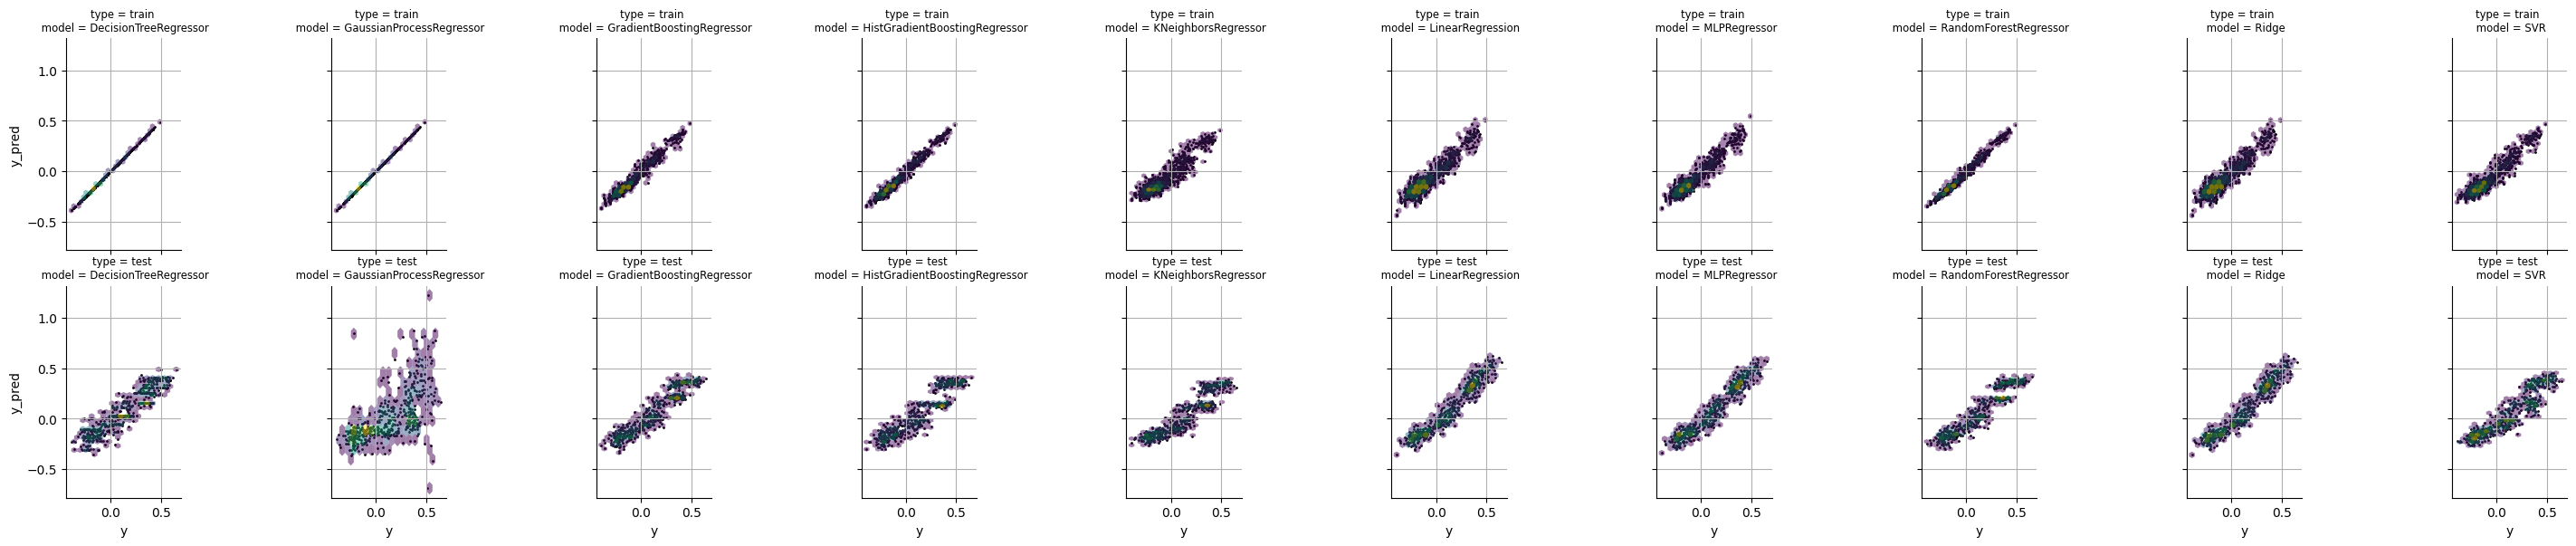

In [143]:
def myhexbin(*args, **kwargs):
        kwargs.pop("color", None)
        hb = plt.hexbin(*args, **kwargs)
        return hb
plt.figure()

g = sns.FacetGrid (all_results_sc, col = 'model', row='type')
g.map(plt.scatter, 'y', 'y_pred', s=1, color = 'black') 
g.map(myhexbin, 'y', 'y_pred', mincnt=1, gridsize=18, alpha = 0.5, edgecolor = None) 

for ax in g.axes.flatten():
        ax.set_title(ax.title.get_text().replace('|', '\n'), fontsize='small')
        ax.set_aspect(1) #'equal')
        ax.grid(zorder=0)

Самые "идеальные" результаты для **тренировочной** выборки дают такие модели, как **DecisionTreeRegressor** и **GaussianProcessRegressor**. Тем не менее, для **тестовой** выборки модель **GaussianProcessRegressor** дает достаточно посредственный, по сравнению с остальными использованными моделями, результат. 

Полученные для остальных моделей диаграммы рассеяния для тренировочной выборки можно условно разделить на 2 группы (*по внешнему виду*): к I относятся результаты для таких моделей, как **GradientBoostingRegressor**, **HistGradientBoostingRegressor**, и **RandomForestRegressor**; ко II - **KNeighborsRegressor**, **LinearRegression**, **MLPRegressor**, **Ridge** и **SVR**. 

Аналогичная "визуальная" закономерность прослеживается и для диаграмм рассеяния, которые были получены для **тестовой** выборки: к группе №1 можно отнести **DecisionTreeRegressor**, **GradientBoostingRegressor**, **HistGradientBoostingRegressor**,**KNeighborsRegressor**, **RandomForestRegressor** и **SVR**; к группе №2 - **LinearRegression**, **MLPRegressor** и **Ridge**.    

Такие опробованные модели, как **LinearRegression** и **Ridge** являются <u>линейными</u>. Единственным представителем класса моделей <u>метода ближайших соседей</u> служит **KNeighborsRegressor**. <u>Метод опорных векторов</u> представлен моделью **SVR**, <u>деревья решений</u> - **DecisionTreeRegressor**, <u>гауссовские процессы</u> - **GaussianProcessRegressor**, <u>многослойный перцептрон</u>- **MLPRegressor**. В качестве <u>ансамблевых</u> моделей были использованы такие модели, как **RandomForestRegressor**, **GradientBoostingRegressor** и **HistGradientBoostingRegressor**.

#### Посмотрим на 3 выбранных **метрики качества** и их неопределенность для **тренировочной** и **тестовой** выборок для **масштабированных** и **немасштабированных** данных. 

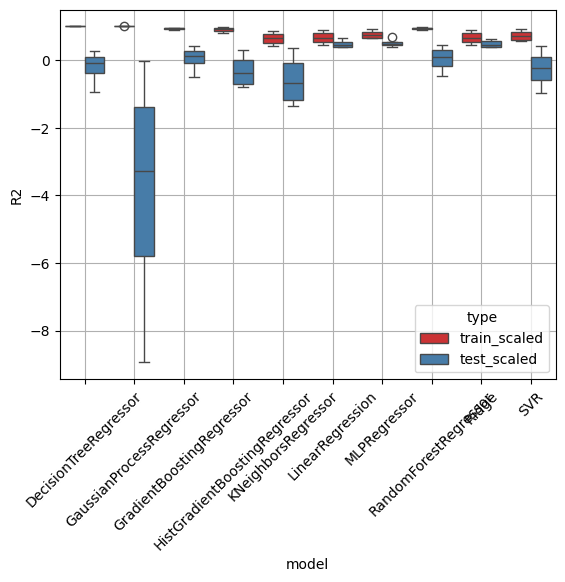

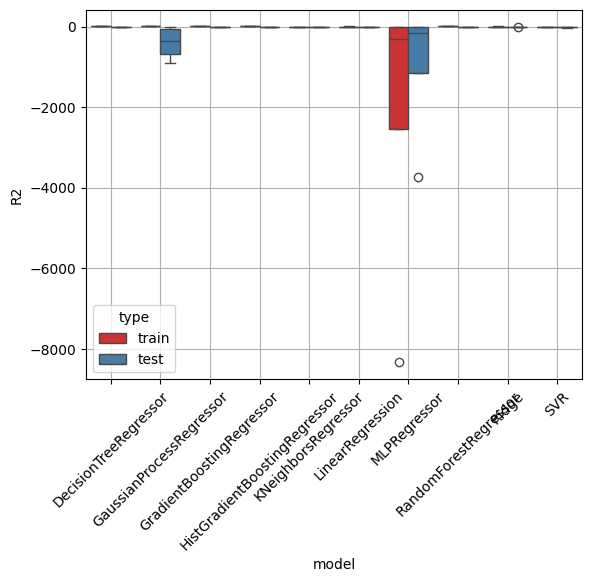

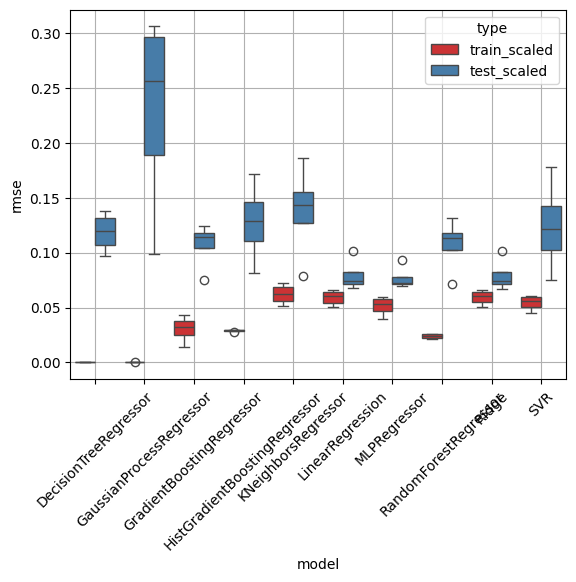

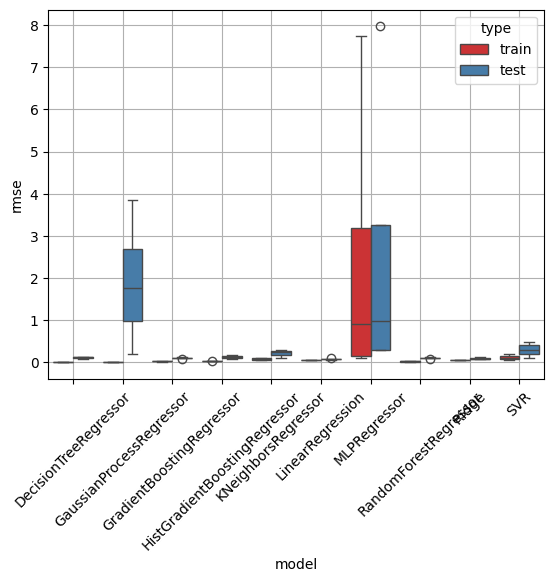

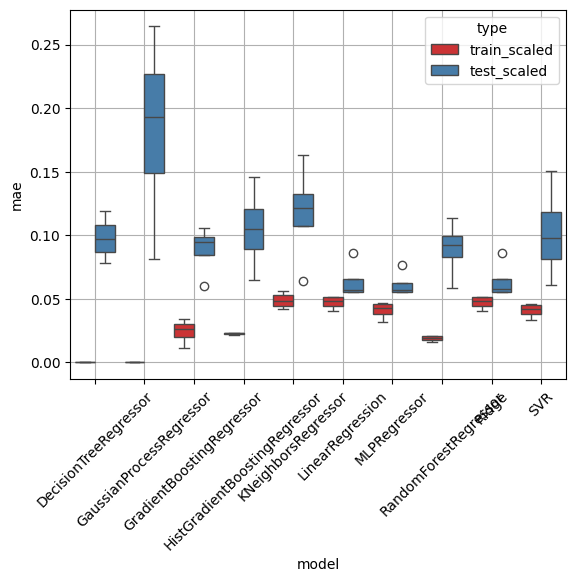

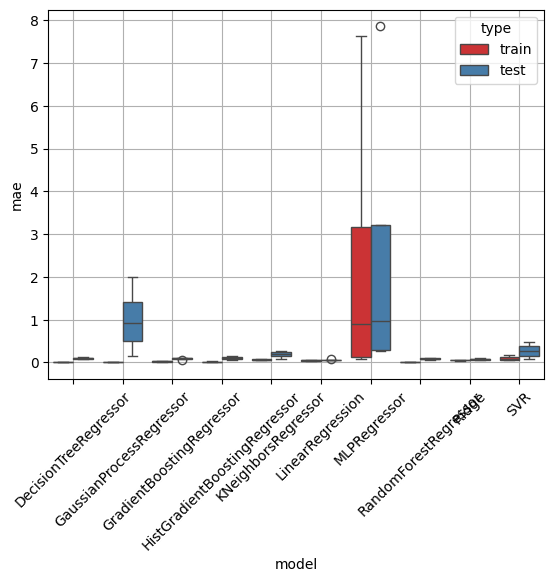

In [146]:
for metric in ['R2', 'rmse', 'mae']:
    df1 = scores_df_sc[['model', 'train_' + metric]].rename(columns={'train_' + metric: metric,})
    df2 = scores_df_sc[['model', 'test_' + metric]].rename(columns={'test_' + metric: metric,})

    df1['type'] = 'train_scaled'
    df2['type'] = 'test_scaled'
    df2boxplot = pd.concat([df1, df2])

    plt.figure()
    sns.boxplot (df2boxplot, x='model', y=metric, hue='type', palette='Set1')
    _ = plt.xticks(rotation=45)
    plt.grid()

    df1 = scores_df[['model', 'train_' + metric]].rename(columns={'train_' + metric: metric,})
    df2 = scores_df[['model', 'test_' + metric]].rename(columns={'test_' + metric: metric,})

    df1['type'] = 'train'
    df2['type'] = 'test'
    df2boxplot = pd.concat([df1, df2])

    plt.figure()
    sns.boxplot (df2boxplot, x='model', y=metric, hue='type', palette='Set1')
    _ = plt.xticks(rotation=45)
    plt.grid()

Полученный на основе **масштабированных** данных график для **коэффициента детерминации** позволяет заключить, что наиболее **нестабильной** с точки зрения этой метрики качества для **тестовой** выборки является модель **GaussianProcessRegressor**, для которой также отмечается наибольшая **неопределенность** (максимальная длина "усов"). "Лучшие" результаты (меньший **разброс**) для **тренировочной** и **тестовой** выборок показывают **GradientBoostingRegressor**, **LinearRegression**, **MLPRegressor**, **RandomForestRegressor** и **Ridge**. С точки зрения **медианного** значения и **обобщательной** способности модели (соответствие коэффициента детерминации для **тренировочной** и **тестовой** выборок) **лучшими** являются **LinearRegression**, **MLPRegressor** и **Ridge**. 

Анализ аналогичного графика для **немасштабированной** целевой переменной позволяет выявить большой **разброс** для модели **LinearRegression** как для **тренировочной**, так и для **тестовой** выборок (является <u>чувствительной</u> к масштабированию). Интересно также отметить, что увеличилась **стабильность** для модели **GaussianProcessRegressor** для **тренировочной** выборки.

Говоря о такой метрике, как **СКО**, стоит отметить, что для **масштабированных** данных, как и в случае **коэффициента детерминации**, наибольшая **нестабильность** в рамках **тестовой** выборки отмечается для модели **GaussianProcessRegressor**. Она является худшей и с точки зрения **медианного** значения. Лучшими в плане **стабильности** и и **обобщательной** способности являются **LinearRegression**, **MLPRegressor** и **Ridge**.

Для **немасштабированной** целевой переменной в рамках метрики **СКО** все модели, за исключением **GaussianProcessRegressor** (для **тестовой** выборки) и **MLPRegressor** (для **тестовой** и **тренировочной** выборок), показывают хорошую **стабильность** и высокую **обобщательную** способность. Отмеченные выше модели отличаются также высокой **неопределенностью**.

С точки зрения **средней абсолютной ошибки** для **масштабированных** и **немасштабированных** данных в целом сохраняются отмеченные для **СКО** закономерности: так, для **масштабированной** целевой переменной худшей **стабильностью** для **тестовой** выборки характеризуется **GaussianProcessRegressor**, а меньшим **разбросом** отмечаются **LinearRegression**, **MLPRegressor** и **Ridge**.

В свою очередь, для **немасштабированных** данных большинство моделей дает аналогичный случаю **СКО** малый **разброс** и большую **обобщательную** способность, а наиболее **неудовлетворительные** результаты с высокой степенью **неопределенности** показывают **GaussianProcessRegressor** (для **тестовой** выборки) и **MLPRegressor** (для 2 типов выборок).

Итак, лучшие результаты для **масшабированных** и **немасштабированных** данных в рамках 2 использованных **метрик качества** даёт такая модель, как **Ridge**.

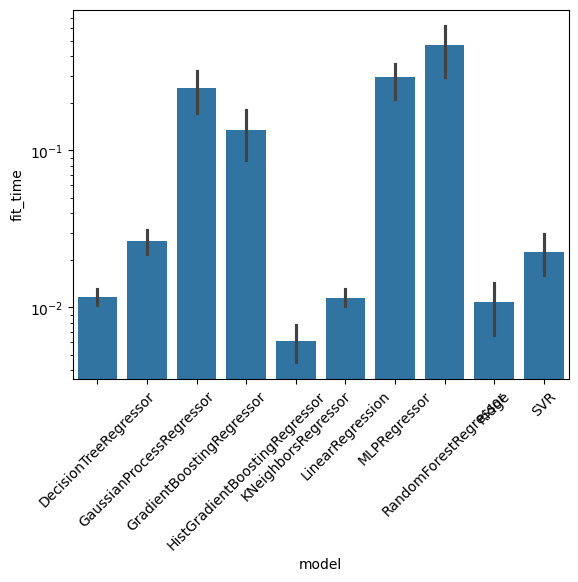

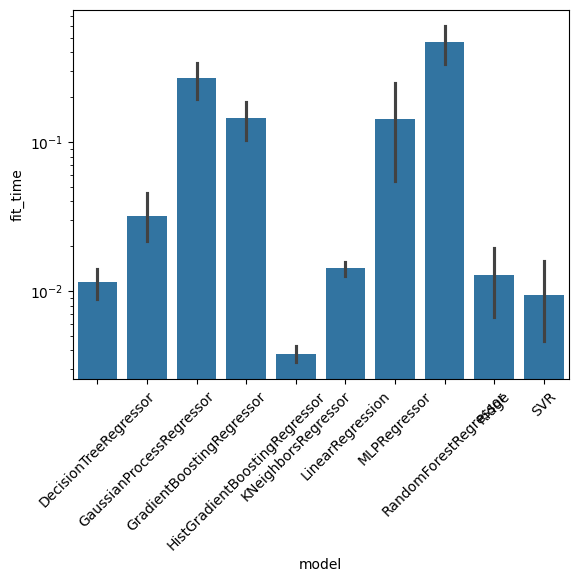

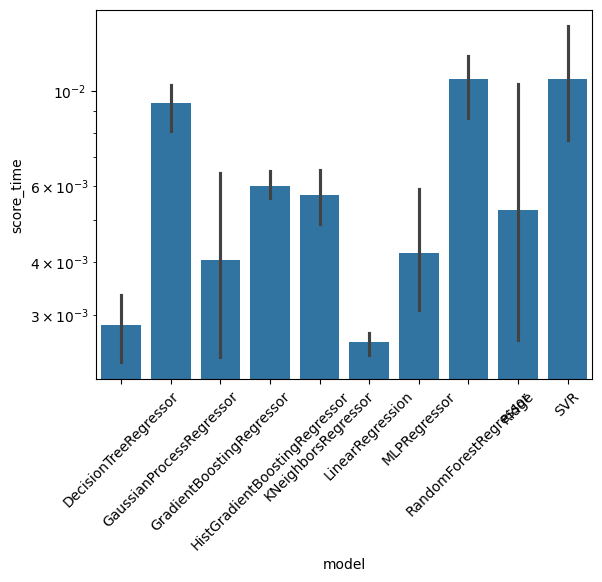

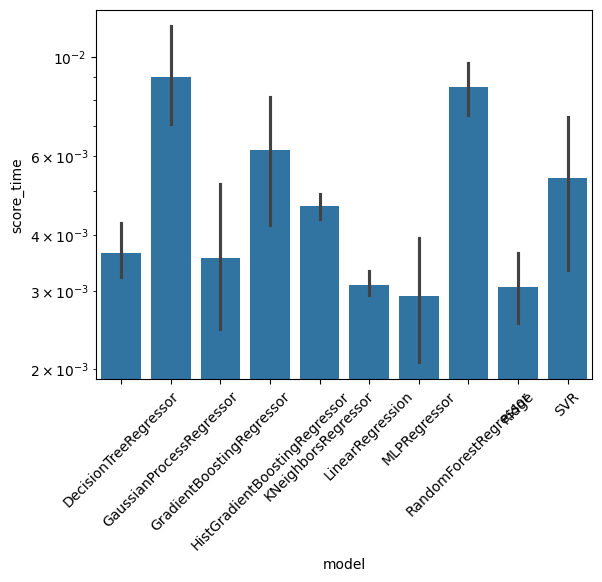

In [148]:
plt.figure()
sns.barplot (scores_df_sc, x='model', y='fit_time')
plt.xticks(rotation=45)
plt.yscale('log')

plt.figure()
sns.barplot (scores_df, x='model', y='fit_time')
plt.xticks(rotation=45)
plt.yscale('log')

plt.figure()
sns.barplot (scores_df_sc, x='model', y='score_time')
plt.xticks(rotation=45)
plt.yscale('log')

plt.figure()
sns.barplot (scores_df, x='model', y='score_time')
plt.xticks(rotation=45)
plt.yscale('log')

С точки зрения **времени обучения модели (fit_time)** для **масшабированных** данных наименьшее время требуется таким моделям, как **DecisionTreeRegressor**, **KNeighborsRegressor** (<u>лучший</u> результат), **LinearRegression** и **Ridge**. Наибольшее время на **обучение** тратят такие модели, как **GradientBoostingRegressor**, **HistGradientBoostingRegressor**, **MLPRegressor** и **RandomForestRegressor**.

Для **немасштабированной** целевой переменной эта закономерность, в целом, сохраняется: быстрее всего **учатся** модели **DecisionTreeRegressor**, **KNeighborsRegressor** (<u>быстрей всего</u>), **Ridge** и **SVR** (вместо **LinearRegression** для **масшабированных** данных). Самыми **медленными**, равно как и для **масштабированной** целевой переменной являются **GradientBoostingRegressor**, **HistGradientBoostingRegressor**, **MLPRegressor** и **RandomForestRegressor**.

Если рассматривать **время прогнозирования (score_time)** для **масшабированных** данных, то **лучшие** результаты дают модели **DecisionTreeRegressor** и **LinearRegression** (<u>лучший</u> результат). **Медленней** всего **прогноз** составляют **GaussianProcessRegressor**, **RandomForestRegressor** и **SVR**. 

Для **немасштабированной** целевой переменной наиболее быстрые **прогнозы** составляют такие модели, как **LinearRegression** (как и для **масштабированных** данных), **MLPRegressor** и **Ridge**. Наиболее долго **считающимися**, как и в случае **масштабированной** целевой переменной, являются **GaussianProcessRegressor**, **HistGradientBoostingRegressor** (*отличие*), **RandomForestRegressor** и **SVR**.

Подводя итог, наиболее **оптимальными** с точки зрения **времени обучения** и **прогнозирования** в рассматриваемом случае для **масшабированных** и **немасшабированных** данных являются такие модели, как **DecisionTreeRegressor**, **KNeighborsRegressor**, **LinearRegression** и **Ridge**. 

#### Оптимизируем гиперпараметры для моделей **GradientBoostingRegressor**, **HistGradientBoostingRegressor**, **RandomForestRegressor** и **MLPRegressor** методом **GridSearch**.

In [209]:
tscv = TimeSeriesSplit(n_splits=3, test_size = 132)

test_size = 132
X_train, X_test = X_array[:-test_size], X_array[-test_size:]
y_train, y_test = y_array[:-test_size], y_array[-test_size:]

model_default = GradientBoostingRegressor()
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)

default_rmse = root_mean_squared_error(y_test, y_pred_default) # СКО
default_mae = mean_absolute_error(y_test, y_pred_default) # средняя абсолютная ошибка

model = GradientBoostingRegressor()
parameters = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.2]}

clf_rmse = GridSearchCV(model, parameters, cv = tscv, n_jobs=8, scoring = 'neg_root_mean_squared_error')
clf_rmse.fit(X_train, y_train)

best_model_rmse = clf_rmse.best_estimator_
y_pred_optim_rmse = best_model_rmse.predict(X_test)

optimized_rmse = root_mean_squared_error(y_test, y_pred_optim_rmse)

clf_mae = GridSearchCV(model, parameters, cv = tscv, n_jobs=8, scoring = 'neg_mean_absolute_error')
clf_mae.fit(X_train, y_train)

best_model_mae = clf_mae.best_estimator_
y_pred_optim_mae = best_model_mae.predict(X_test)

optimized_mae = mean_absolute_error(y_test, y_pred_optim_mae)

print(f'RMSE для GradientBoostingRegressor по умолчанию: {default_rmse:.4f}')
print(f'RMSE для оптимизированной GradientBoostingRegressor: {optimized_rmse:.4f}')
print(f'Лучшие параметры для GradientBoostingRegressor с точки зрения RMSE: {clf_rmse.best_params_}')

print(f'MAE для GradientBoostingRegressor по умолчанию: {default_mae:.4f}')
print(f'MAE для оптимизированной GradientBoostingRegressor: {optimized_mae:.4f}')
print(f'Лучшие параметры для GradientBoostingRegressor с точки зрения MAE: {clf_mae.best_params_}')

print(f'R2 для GradientBoostingRegressor по умолчанию: {default_r2:.4f}')
print(f'R2 для оптимизированной GradientBoostingRegressor: {optimized_r2:.4f}')
print(f'Лучшие параметры для GradientBoostingRegressor с точки зрения R2: {clf_r2.best_params_}')

default_score_rmse = cross_val_score(model_default, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

optimized_score_rmse = cross_val_score(best_model_rmse, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

print('Статистическая значимость улучшения 2 метрик для GradientBoostingRegressor')

t_stat_rmse, p_value_rmse = stats.ttest_rel(default_score_rmse, optimized_score_rmse)
print(f'T-stat: {t_stat_rmse:.4f}, p-value: {p_value_rmse:.4f}')
if p_value_rmse < 0.05:
    print('Улучшение RMSE статистически ЗНАЧИМО')
else:
    print('Улучшение RMSE статистически НЕ ЗНАЧИМО')

default_score_mae = cross_val_score(model_default, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

optimized_score_mae = cross_val_score(best_model_mae, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

t_stat_mae, p_value_mae = stats.ttest_rel(default_score_mae, optimized_score_mae)
print(f'T-stat: {t_stat_mae:.4f}, p-value: {p_value_mae:.4f}')
if p_value_mae < 0.05:
    print('Улучшение MAE статистически ЗНАЧИМО')
else:
    print('Улучшение MAE статистически НЕ ЗНАЧИМО')

RMSE для GradientBoostingRegressor по умолчанию: 0.1136
RMSE для оптимизированной GradientBoostingRegressor: 0.1141
Лучшие параметры для GradientBoostingRegressor с точки зрения RMSE: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
MAE для GradientBoostingRegressor по умолчанию: 0.0925
MAE для оптимизированной GradientBoostingRegressor: 0.0930
Лучшие параметры для GradientBoostingRegressor с точки зрения MAE: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
R2 для GradientBoostingRegressor по умолчанию: -0.4888
R2 для оптимизированной GradientBoostingRegressor: -0.5304
Лучшие параметры для GradientBoostingRegressor с точки зрения R2: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Статистическая значимость улучшения 2 метрик для GradientBoostingRegressor
T-stat: -0.6400, p-value: 0.5877
Улучшение RMSE статистически НЕ ЗНАЧИМО
T-stat: -1.0752, p-value: 0.3948
Улучшение MAE статистически НЕ ЗНАЧИМО


In [210]:
model_default = HistGradientBoostingRegressor()
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)

default_rmse = root_mean_squared_error(y_test, y_pred_default) # СКО
default_mae = mean_absolute_error(y_test, y_pred_default) # средняя абсолютная ошибка

model = HistGradientBoostingRegressor()
parameters = {'min_samples_leaf': [5, 10, 20], 'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1, 0.2]}

clf_rmse = GridSearchCV(model, parameters, cv = tscv, n_jobs=8, scoring = 'neg_root_mean_squared_error')
clf_rmse.fit(X_train, y_train)

best_model_rmse = clf_rmse.best_estimator_
y_pred_optim_rmse = best_model_rmse.predict(X_test)

optimized_rmse = root_mean_squared_error(y_test, y_pred_optim_rmse)

clf_mae = GridSearchCV(model, parameters, cv = tscv, n_jobs=8, scoring = 'neg_mean_absolute_error')
clf_mae.fit(X_train, y_train)

best_model_mae = clf_mae.best_estimator_
y_pred_optim_mae = best_model_mae.predict(X_test)

optimized_mae = mean_absolute_error(y_test, y_pred_optim_mae)

print(f'RMSE для HistGradientBoostingRegressor по умолчанию: {default_rmse:.4f}')
print(f'RMSE для оптимизированной HistGradientBoostingRegressor: {optimized_rmse:.4f}')
print(f'Лучшие параметры для HistGradientBoostingRegressor с точки зрения RMSE: {clf_rmse.best_params_}')

print(f'MAE для HistGradientBoostingRegressor по умолчанию: {default_mae:.4f}')
print(f'MAE для оптимизированной HistGradientBoostingRegressor: {optimized_mae:.4f}')
print(f'Лучшие параметры для HistGradientBoostingRegressor с точки зрения MAE: {clf_mae.best_params_}')

default_score_rmse = cross_val_score(model_default, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

optimized_score_rmse = cross_val_score(best_model_rmse, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

print('Статистическая значимость улучшения 2 метрик для HistGradientBoostingRegressor')

t_stat_rmse, p_value_rmse = stats.ttest_rel(default_score_rmse, optimized_score_rmse)
print(f'T-stat: {t_stat_rmse:.4f}, p-value: {p_value_rmse:.4f}')
if p_value_rmse < 0.05:
    print('Улучшение RMSE статистически ЗНАЧИМО')
else:
    print('Улучшение RMSE статистически НЕ ЗНАЧИМО')

default_score_mae = cross_val_score(model_default, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

optimized_score_mae = cross_val_score(best_model_mae, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

t_stat_mae, p_value_mae = stats.ttest_rel(default_score_mae, optimized_score_mae)
print(f'T-stat: {t_stat_mae:.4f}, p-value: {p_value_mae:.4f}')
if p_value_mae < 0.05:
    print('Улучшение MAE статистически ЗНАЧИМО')
else:
    print('Улучшение MAE статистически НЕ ЗНАЧИМО')

RMSE для HistGradientBoostingRegressor по умолчанию: 0.1203
RMSE для оптимизированной HistGradientBoostingRegressor: 0.1113
Лучшие параметры для HistGradientBoostingRegressor с точки зрения RMSE: {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 5}
MAE для HistGradientBoostingRegressor по умолчанию: 0.0973
MAE для оптимизированной HistGradientBoostingRegressor: 0.0888
Лучшие параметры для HistGradientBoostingRegressor с точки зрения MAE: {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 5}
Статистическая значимость улучшения 2 метрик для HistGradientBoostingRegressor
T-stat: -2.3423, p-value: 0.1439
Улучшение RMSE статистически НЕ ЗНАЧИМО
T-stat: -2.1622, p-value: 0.1631
Улучшение MAE статистически НЕ ЗНАЧИМО


In [213]:
model_default = RandomForestRegressor()
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)

default_rmse = root_mean_squared_error(y_test, y_pred_default) # СКО
default_mae = mean_absolute_error(y_test, y_pred_default) # средняя абсолютная ошибка

model = RandomForestRegressor()
parameters = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]}

clf_rmse = GridSearchCV(model, parameters, cv = tscv, n_jobs=8, scoring = 'neg_root_mean_squared_error')
clf_rmse.fit(X_train, y_train)

best_model_rmse = clf_rmse.best_estimator_
y_pred_optim_rmse = best_model_rmse.predict(X_test)

optimized_rmse = root_mean_squared_error(y_test, y_pred_optim_rmse)

clf_mae = GridSearchCV(model, parameters, cv = tscv, n_jobs=8, scoring = 'neg_mean_absolute_error')
clf_mae.fit(X_train, y_train)

best_model_mae = clf_mae.best_estimator_
y_pred_optim_mae = best_model_mae.predict(X_test)

optimized_mae = mean_absolute_error(y_test, y_pred_optim_mae)

print(f'RMSE для RandomForestRegressor по умолчанию: {default_rmse:.4f}')
print(f'RMSE для оптимизированной RandomForestRegressor: {optimized_rmse:.4f}')
print(f'Лучшие параметры для RandomForestRegressor с точки зрения RMSE: {clf_rmse.best_params_}')

print(f'MAE для RandomForestRegressor по умолчанию: {default_mae:.4f}')
print(f'MAE для оптимизированной RandomForestRegressor: {optimized_mae:.4f}')
print(f'Лучшие параметры для RandomForestRegressor с точки зрения MAE: {clf_mae.best_params_}')

default_score_rmse = cross_val_score(model_default, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

optimized_score_rmse = cross_val_score(best_model_rmse, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

print('Статистическая значимость улучшения 2 метрик для RandomForestRegressor')

t_stat_rmse, p_value_rmse = stats.ttest_rel(default_score_rmse, optimized_score_rmse)
print(f'T-stat: {t_stat_rmse:.4f}, p-value: {p_value_rmse:.4f}')
if p_value_rmse < 0.05:
    print('Улучшение RMSE статистически ЗНАЧИМО')
else:
    print('Улучшение RMSE статистически НЕ ЗНАЧИМО')

default_score_mae = cross_val_score(model_default, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

optimized_score_mae = cross_val_score(best_model_mae, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

t_stat_mae, p_value_mae = stats.ttest_rel(default_score_mae, optimized_score_mae)
print(f'T-stat: {t_stat_mae:.4f}, p-value: {p_value_mae:.4f}')
if p_value_mae < 0.05:
    print('Улучшение MAE статистически ЗНАЧИМО')
else:
    print('Улучшение MAE статистически НЕ ЗНАЧИМО')

RMSE для RandomForestRegressor по умолчанию: 0.1099
RMSE для оптимизированной RandomForestRegressor: 0.1132
Лучшие параметры для RandomForestRegressor с точки зрения RMSE: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}
MAE для RandomForestRegressor по умолчанию: 0.0888
MAE для оптимизированной RandomForestRegressor: 0.0915
Лучшие параметры для RandomForestRegressor с точки зрения MAE: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Статистическая значимость улучшения 2 метрик для RandomForestRegressor
T-stat: 0.7022, p-value: 0.5553
Улучшение RMSE статистически НЕ ЗНАЧИМО
T-stat: -1.4584, p-value: 0.2821
Улучшение MAE статистически НЕ ЗНАЧИМО


In [214]:
model_default = MLPRegressor()
model_default.fit(X_train, y_train)
y_pred_default = model_default.predict(X_test)

default_rmse = root_mean_squared_error(y_test, y_pred_default) # СКО
default_mae = mean_absolute_error(y_test, y_pred_default) # средняя абсолютная ошибка

model = MLPRegressor()
parameters = {'alpha': [0.0001, 0.001, 0.01], 'learning_rate_init': [0.001, 0.005, 0.01], 'max_iter': [200, 500, 700]}

clf_rmse = GridSearchCV(model, parameters, cv = tscv, n_jobs=8, scoring = 'neg_root_mean_squared_error')
clf_rmse.fit(X_train, y_train)

best_model_rmse = clf_rmse.best_estimator_
y_pred_optim_rmse = best_model_rmse.predict(X_test)

optimized_rmse = root_mean_squared_error(y_test, y_pred_optim_rmse)

clf_mae = GridSearchCV(model, parameters, cv = tscv, n_jobs=8, scoring = 'neg_mean_absolute_error')
clf_mae.fit(X_train, y_train)

best_model_mae = clf_mae.best_estimator_
y_pred_optim_mae = best_model_mae.predict(X_test)

optimized_mae = mean_absolute_error(y_test, y_pred_optim_mae)

print(f'RMSE для MLPRegressor по умолчанию: {default_rmse:.4f}')
print(f'RMSE для оптимизированной MLPRegressor: {optimized_rmse:.4f}')
print(f'Лучшие параметры для MLPRegressor с точки зрения RMSE: {clf_rmse.best_params_}')

print(f'MAE для MLPRegressor по умолчанию: {default_mae:.4f}')
print(f'MAE для оптимизированной MLPRegressor: {optimized_mae:.4f}')
print(f'Лучшие параметры для MLPRegressor с точки зрения MAE: {clf_mae.best_params_}')

default_score_rmse = cross_val_score(model_default, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

optimized_score_rmse = cross_val_score(best_model_rmse, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')

print('Статистическая значимость улучшения 2 метрик для MLPRegressor')

t_stat_rmse, p_value_rmse = stats.ttest_rel(default_score_rmse, optimized_score_rmse)
print(f'T-stat: {t_stat_rmse:.4f}, p-value: {p_value_rmse:.4f}')
if p_value_rmse < 0.05:
    print('Улучшение RMSE статистически ЗНАЧИМО')
else:
    print('Улучшение RMSE статистически НЕ ЗНАЧИМО')

default_score_mae = cross_val_score(model_default, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

optimized_score_mae = cross_val_score(best_model_mae, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error')

t_stat_mae, p_value_mae = stats.ttest_rel(default_score_mae, optimized_score_mae)
print(f'T-stat: {t_stat_mae:.4f}, p-value: {p_value_mae:.4f}')
if p_value_mae < 0.05:
    print('Улучшение MAE статистически ЗНАЧИМО')
else:
    print('Улучшение MAE статистически НЕ ЗНАЧИМО')

RMSE для MLPRegressor по умолчанию: 0.2422
RMSE для оптимизированной MLPRegressor: 0.0896
Лучшие параметры для MLPRegressor с точки зрения RMSE: {'alpha': 0.001, 'learning_rate_init': 0.005, 'max_iter': 700}
MAE для MLPRegressor по умолчанию: 0.2266
MAE для оптимизированной MLPRegressor: 0.0841
Лучшие параметры для MLPRegressor с точки зрения MAE: {'alpha': 0.001, 'learning_rate_init': 0.005, 'max_iter': 700}
Статистическая значимость улучшения 2 метрик для MLPRegressor
T-stat: -0.9930, p-value: 0.4254
Улучшение RMSE статистически НЕ ЗНАЧИМО
T-stat: -0.9959, p-value: 0.4242
Улучшение MAE статистически НЕ ЗНАЧИМО


С точки зрения **СКО** и **средней абсолютной ошибки** проведем сравнение каждой модели с конфигурацией гиперпараметров **по умолчанию** и с **оптимизированными** гиперпараметрами. Можно отметить, что для модели **GradientBoostingRegressor** при **оптимизации** гиперпараметров (*learning_rate = 0.1, max_depth = 3, n_estimators = 200*) **RMSE** и **MAE** <u>увеличиваются</u> на 0.0005 (*статистически не значимо*), т.е. её результаты <u>ухудшаются</u>. Для оптимизированной (*learning_rate = 0.1, max_depth = 10, min_samples_leaf = 5*) **HistGradientBoostingRegressor** наблюдается <u>улучшение</u> результатов в рамках 2 выбранных **метрик качества**: так, **RMSE** уменьшается на 0.009 (*статистически не значимо*), а **MAE**- на 0.0085 (*статистически не значимо*). Для **оптимизированной** (*max_depth = 20, min_samples_split = 10, n_estimators = 50* для **RMSE** и *max_depth = None, min_samples_split = 2, n_estimators = 50* для **MAE**) **RandomForestRegressor** вновь наблюдается <u>ухудшение</u> результатов по сравнению с конфигурацией *по умолчанию*: **RMSE** и **MAE** <u>увеличиваются</u> на 0.0033 и 0.0027 соответственно (*статистически не значимо*). Для модели **MLPRegressor** с **оптимизацией** гиперпараметров (*alpha = 0.001, learning_rate_init = 0.005, max_iter = 700*) наблюдается <u>улучшение</u> качества с точки зрения **СКО** и **средней абсолютной ошибки**: **RMSE** уменьшается на 0.1526 (*статистически не значимо*), а **MAE** - на 0.1425 (*статистически не значимо*).

#### Проанализируем глобальную значимость признаков в подходе **перестановочной важности признаков (permutation feature importance)** для **масштабированных** и **немасштабированных** данных

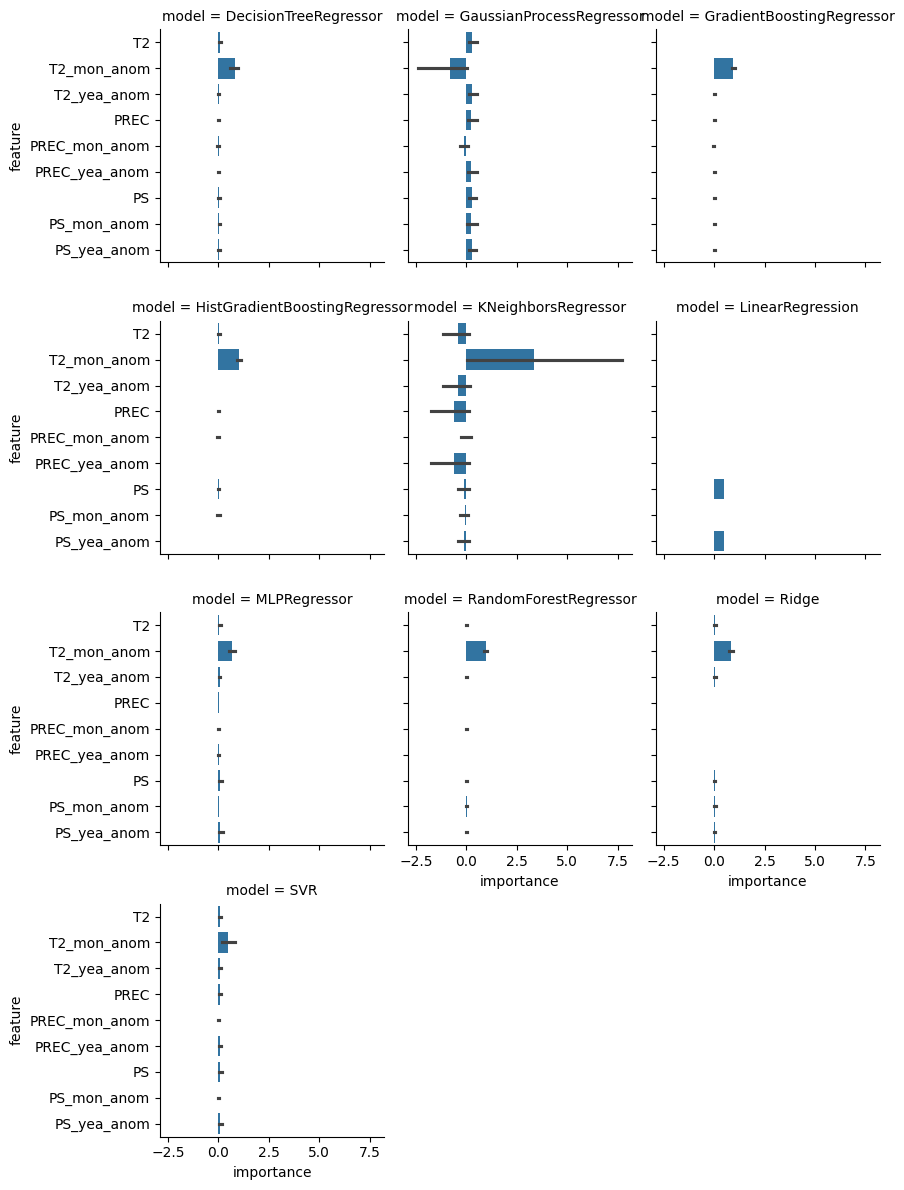

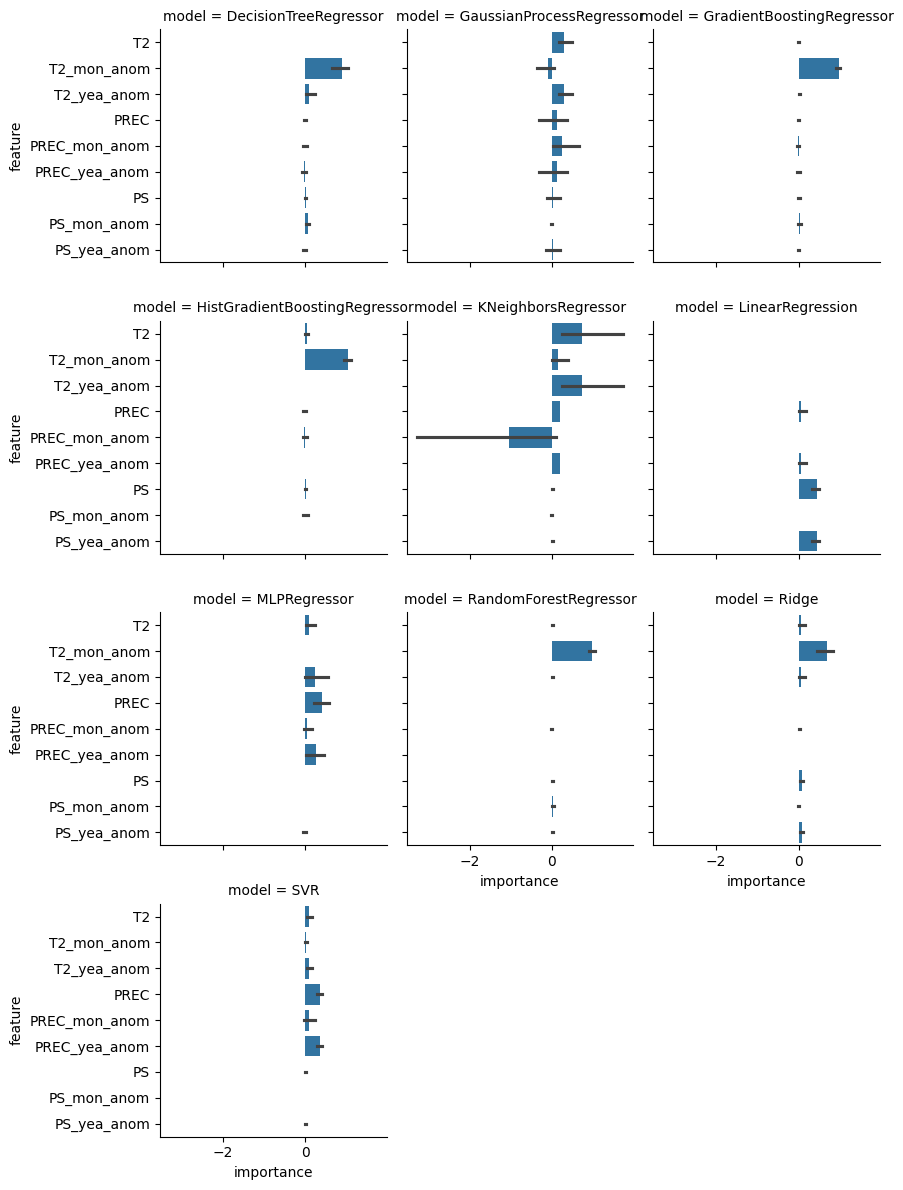

In [11]:
feature_importance = []

for i in scores_df_sc.index:
    cur_y_test  = y_array[scores_df_sc.loc[i, 'test_idx']]
    cur_X_test  = X_array[scores_df_sc.loc[i, 'test_idx']]

    result_r2 = permutation_importance(scores_df_sc.loc[i, 'estimator'], cur_X_test, cur_y_test, n_repeats=5,
                                    random_state=0, n_jobs = 8, scoring='r2')

    feature_importance.append(pd.DataFrame({'importance': result_r2['importances_mean']/np.sum(result_r2['importances_mean']),
                                            'model': scores_df_sc['model'][i], 'feature': X.columns}))   

feature_importance = pd.concat(feature_importance)

g = sns.FacetGrid (feature_importance, col = 'model', col_wrap=3)
g.map (sns.barplot, 'importance', 'feature', order = X.columns)

feature_importance = []

for i in scores_df.index:
    cur_y_test  = y_array[scores_df.loc[i, 'test_idx']]
    cur_X_test  = X_array[scores_df.loc[i, 'test_idx']]

    result_r2 = permutation_importance(scores_df.loc[i, 'estimator'], cur_X_test, cur_y_test, n_repeats=5,
                                    random_state=0, n_jobs = 8, scoring='r2')

    feature_importance.append(pd.DataFrame({'importance': result_r2['importances_mean']/np.sum(result_r2['importances_mean']),
                                            'model': scores_df['model'][i], 'feature': X.columns}))   

feature_importance = pd.concat(feature_importance)

g = sns.FacetGrid (feature_importance, col = 'model', col_wrap=3)
g.map (sns.barplot, 'importance', 'feature', order = X.columns)

Для начала проанализируем наиболее **значимые** признаки в подходе **перестановочной важности признаков** для **масштабированных** данных. Для таких моделей, как **DecisionTreeRegressor**, **GradientBoostingRegressor**, **HistGradientBoostingRegressor**, **MLPRegressor**, **RandomForestRegressor**, **Ridge** и **SVR** наибольший <u>положительный</u> вклад имеет *среднемесячная аномалия температуры воздуха на 2 м*. Для модели **GradientBoostingRegressor** другие признаки влияния практически не оказывают. Интересно отметить, что для **GaussianProcessRegressor** вклад этого признака также является максимальным, но в <u>отрицательную</u> сторону. Для **KNeighborsRegressor** вклад *среднемесячной аномалии температуры воздуха на 2 м* также максимален и <u>положителен</u>, но в отличие от других моделей и наряду с **GaussianProcessRegressor** здесь оказывают достаточно заметное влияние остальные признаки - *температура воздуха на 2 м*, *ее среднегодовая аномалия*, *атмосферные осадки* и их *среднемесячные* и *среднегодовые аномалии* (более значительное влияние на среднегодовом масштабе), *давление на уровне моря* и его *среднемесячная* и *среднегодовая аномалии*. Важно также подчеркнуть, что для **KNeighborsRegressor** вклад *температуры воздуха на 2 м*, *ее среднегодовой аномалии*, *атмосферных осадков* и их *среднегодовых аномалий* имеет <u>отрицательный</u> знак. Исключением также является **LinearRegression**, для которой наибольший <u>положительный</u> вклад оказывает *давление на уровне моря* и его *среднегодовая аномалия*.

Теперь перейдем к рассмотрению наиболее **значимых** признаков в подходе **permutation feature importance** для **немасштабированных** данных. Для **DecisionTreeRegressor**, **GradientBoostingRegressor**, **HistGradientBoostingRegressor**, **RandomForestRegressor** и **Ridge** вновь максимальный <u>положительный</u> вклад дает *среднемесячная аномалия температуры воздуха на 2 м*. Для моделей **GradientBoostingRegressor** и **RandomForestRegressor** другие признаки влияния практически не оказывают. Для таких моделей, как **GaussianProcessRegressor**, **KNeighborsRegressor**, **LinearRegression**, **MLPRegressor** и **SVR** вклад *среднемесячной аномалии температуры воздуха на 2 м* не является <u>ключевым</u> фактором. Для **GaussianProcessRegressor** вклад *температуры воздуха на 2 м*, *ее среднегодовой аномалии*, *среднемесячной аномалии атмосферных осадков* имеет примерно одинаковый порядок. Вклад *атмосферных осадков* и их *среднегодовой аномалии* также примерно эквивалентен. Как и в случае **масштабированных** данных, вклад *среднемесячной аномалии температуры воздуха на 2 м* имеет <u>отрицательный</u> знак. Для **KNeighborsRegressor** максимальное <u>отрицательное</u> влияние оказывает *среднемесячная аномалия атмосферных осадков*, а <u>положительное</u> - *температура воздуха на 2 м* и *ее среднегодовая аномалия*. В модели **LinearRegression**, как и в случае **масштабированных** данных, наибольшее <u>положительное</u> влияние имеют *давление на уровне моря* и его *среднегодовая аномалия*.
Для модели **MLPRegressor** примерно равный <u>положительный</u> эффект вносят *среднегодовая аномалия температуры воздуха на 2 м*, *атмосферные осадки* и их *среднегодовая аномалия*. Для **SVR** примерно равное влияние оказывают *атмосферные осадки* и их *среднегодовая аномалия*, а также *температура воздуха на 2 м* и *ее среднегодовая аномалия* и *среднемесячная аномалия атмосферных осадков*.

#### Проанализируем локальную значимость признаков с помошью метода **LIME** для **масштабированных** и **немасштабированных** данных

In [28]:
test_size = 132
X_train, X_test = X_array[:-test_size], X_array[-test_size:]
y_train, y_test = y_array[:-test_size], y_array[-test_size:]

models = [DecisionTreeRegressor(),
          GaussianProcessRegressor(),
          GradientBoostingRegressor(),
          HistGradientBoostingRegressor(),
          KNeighborsRegressor(),
          LinearRegression(), 
          MLPRegressor(),
          RandomForestRegressor(),
          Ridge(),
          SVR()] 

results = {}
predictions = {}

for mod in tqdm(models, desc='Модели с маштабированием'):
    mod_name = mod.__class__.__name__
    model = Pipeline([
                    ('scaler', StandardScaler(with_mean=True, with_std=True)),
                    ('regressor', TransformedTargetRegressor(regressor=mod, transformer=StandardScaler(with_mean=True, with_std=True)))
                    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[mod_name] = {
        'R2': r2_score(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'model': model
    }
    predictions[mod_name] = y_pred

    print(f"R2: {results[mod_name]['R2']:.3f}")
    print(f"RMSE: {results[mod_name]['RMSE']:.3f}")
    print(f"MAE: {results[mod_name]['MAE']:.3f}")

if results:
    best_model_name = max(results, key=lambda x: results[x]['R2'])
    best_model = results[best_model_name]['model']
    best_y_pred = predictions[best_model_name]

    print(f'Лучшая модель: {best_model_name}')
    print(f"R2: {results[best_model_name]['R2']:.3f}")
    print(f"RMSE: {results[best_model_name]['RMSE']:.3f}")
    print(f"MAE: {results[best_model_name]['MAE']:.3f}")

# Создание объекта LIME для табличных данных
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train, 
                                                   feature_names=features,
                                                   class_names=['SST_mon_anom'],  
                                                   mode='regression', 
                                                   discretize_continuous=False)

# Выбор примера из тестового набора для интерпретации
i = 10  # пример для интерпретации
print(f'Интерпретация примера {i}:')
print(f'Лучшая модель: {best_model_name}:')
print(f'Истинное значение: {y_test[i]:.3f}')
print(f'Предсказанное значение: {best_y_pred[i]:.3f}')
print(f'Признаки примера:')
for feat, val in zip(features, X_test[i]):
    print(f"{feat}: {val:.3f}")

exp = explainer.explain_instance(X_test[i], predict_fn=best_model.predict, num_features=len(features))

print('Сравнение всех моделей:')
results_df = pd.DataFrame(results).T
print(results_df[['R2', 'RMSE', 'MAE']].sort_values('R2', ascending=False))
print(results_df)

Модели с маштабированием:  20%|██        | 2/10 [00:00<00:00,  8.12it/s]

R2: -0.896
RMSE: 0.128
MAE: 0.103
R2: -8.943
RMSE: 0.293
MAE: 0.215


Модели с маштабированием:  30%|███       | 3/10 [00:00<00:01,  5.70it/s]

R2: -0.493
RMSE: 0.114
MAE: 0.092


Модели с маштабированием:  40%|████      | 4/10 [00:00<00:01,  5.02it/s]

R2: -0.671
RMSE: 0.120
MAE: 0.097
R2: -1.362
RMSE: 0.143
MAE: 0.122
R2: 0.399
RMSE: 0.072
MAE: 0.056


Модели с маштабированием:  70%|███████   | 7/10 [00:01<00:00,  7.54it/s]

R2: 0.314
RMSE: 0.077
MAE: 0.059


Модели с маштабированием: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]

R2: -0.467
RMSE: 0.113
MAE: 0.091
R2: 0.394
RMSE: 0.072
MAE: 0.056
R2: -0.449
RMSE: 0.112
MAE: 0.088
Лучшая модель: LinearRegression
R2: 0.399
RMSE: 0.072
MAE: 0.056
Интерпретация примера 10:
Лучшая модель: LinearRegression:
Истинное значение: 0.552
Предсказанное значение: 0.439
Признаки примера:
T2: 13.314
T2_mon_anom: 0.573
PREC: -0.465
PREC_mon_anom: 90.626
PS: 1.370
PS_mon_anom: -1.830
Сравнение всех моделей:
                                     R2      RMSE       MAE
LinearRegression               0.398868  0.072142  0.055606
Ridge                          0.394164  0.072423  0.055818
MLPRegressor                   0.314443  0.077041  0.058718
SVR                             -0.4486  0.111989    0.0882
RandomForestRegressor          -0.46741  0.112714  0.090645
GradientBoostingRegressor     -0.493151  0.113698  0.092455
HistGradientBoostingRegressor -0.670988  0.120278  0.097327
DecisionTreeRegressor         -0.895509  0.128104  0.102526
KNeighborsRegressor           -1.362095  0.

С точки зрения **локальной** значимости признаков, измеренной с помошью метода **LIME** для **масштабированных** данных, лучшей моделью является **LinearRegression** с **коэффициентом детерминации** равным 0.399, **СКО** и **средней абсолютной ошибкой** равными 0.072 и 0.056 соответственно. Она же является лучшей для выбранного примера (*10 временной срез*). Наибольший <u>положительный</u> вклад вносит *среднемесячная аномалия атмосферных осадков* и *температура воздуха на 2 м*, а наиболее <u>отрицательный</u> - *среднемесячная аномалия давления на уровне моря*. 

In [30]:
test_size = 132
X_train, X_test = X_array[:-test_size], X_array[-test_size:]
y_train, y_test = y_array[:-test_size], y_array[-test_size:]

models = [DecisionTreeRegressor(),
          GaussianProcessRegressor(),
          GradientBoostingRegressor(),
          HistGradientBoostingRegressor(),
          KNeighborsRegressor(),
          LinearRegression(), 
          MLPRegressor(),
          RandomForestRegressor(),
          Ridge(),
          SVR()] 

results = {}
predictions = {}

for mod in tqdm(models, desc='Модели без маштабирования'):
    mod_name = mod.__class__.__name__
    model = Pipeline([
                    ('scaler', StandardScaler(with_mean=False, with_std=False)),
                    ('regressor', TransformedTargetRegressor(regressor=mod, transformer=StandardScaler(with_mean=False, with_std=False)))
                    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[mod_name] = {
        'R2': r2_score(y_test, y_pred),
        'RMSE': root_mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'model': model
    }
    predictions[mod_name] = y_pred

    print(f"R2: {results[mod_name]['R2']:.3f}")
    print(f"RMSE: {results[mod_name]['RMSE']:.3f}")
    print(f"MAE: {results[mod_name]['MAE']:.3f}")

if results:
    best_model_name = max(results, key=lambda x: results[x]['R2'])
    best_model = results[best_model_name]['model']
    best_y_pred = predictions[best_model_name]

    print(f'Лучшая модель: {best_model_name}')
    print(f"R2: {results[best_model_name]['R2']:.3f}")
    print(f"RMSE: {results[best_model_name]['RMSE']:.3f}")
    print(f"MAE: {results[best_model_name]['MAE']:.3f}")

# Создание объекта LIME для табличных данных
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train, 
                                                   feature_names=features,
                                                   class_names=['SST_mon_anom'],  
                                                   mode='regression', 
                                                   discretize_continuous=False)

# Выбор примера из тестового набора для интерпретации
i = 10  # пример для интерпретации
print(f'Интерпретация примера {i}:')
print(f'Лучшая модель: {best_model_name}:')
print(f'Истинное значение: {y_test[i]:.3f}')
print(f'Предсказанное значение: {best_y_pred[i]:.3f}')
print(f'Признаки примера:')
for feat, val in zip(features, X_test[i]):
    print(f"{feat}: {val:.3f}")

exp = explainer.explain_instance(X_test[i], predict_fn=best_model.predict, num_features=len(features))

print('Сравнение всех моделей:')
results_df = pd.DataFrame(results).T
print(results_df[['R2', 'RMSE', 'MAE']].sort_values('R2', ascending=False))
print(results_df)

Модели без маштабирования:  20%|██        | 2/10 [00:00<00:00, 13.32it/s]

R2: -0.943
RMSE: 0.130
MAE: 0.104
R2: -615.872
RMSE: 2.311
MAE: 1.225
R2: -0.480
RMSE: 0.113
MAE: 0.092


Модели без маштабирования:  70%|███████   | 7/10 [00:00<00:00,  9.85it/s]

R2: -0.671
RMSE: 0.120
MAE: 0.097
R2: -7.004
RMSE: 0.263
MAE: 0.227
R2: 0.397
RMSE: 0.072
MAE: 0.056
R2: -11.032
RMSE: 0.323
MAE: 0.306


Модели без маштабирования: 100%|██████████| 10/10 [00:01<00:00,  8.64it/s]

R2: -0.460
RMSE: 0.112
MAE: 0.090
R2: 0.298
RMSE: 0.078
MAE: 0.061
R2: -26.039
RMSE: 0.484
MAE: 0.475
Лучшая модель: LinearRegression
R2: 0.397
RMSE: 0.072
MAE: 0.056
Интерпретация примера 10:
Лучшая модель: LinearRegression:
Истинное значение: 0.552
Предсказанное значение: 0.439
Признаки примера:
T2: 13.314
T2_mon_anom: 0.573
PREC: -0.465
PREC_mon_anom: 90.626
PS: 1.370
PS_mon_anom: -1.830
Сравнение всех моделей:
                                       R2      RMSE       MAE
LinearRegression                 0.397115  0.072247  0.055718
Ridge                            0.297737  0.077974  0.060673
RandomForestRegressor           -0.459768   0.11242  0.090393
GradientBoostingRegressor       -0.480053  0.113198  0.092103
HistGradientBoostingRegressor   -0.670988  0.120278  0.097327
DecisionTreeRegressor           -0.943045  0.129701  0.104079
KNeighborsRegressor             -7.003527  0.263234  0.227449
MLPRegressor                    -11.03249   0.32276  0.305861
SVR                     

Для **немасштабированных** данных наиболее удачной с позиции **локальной** значимости признаков (метод **LIME**) также является модель **LinearRegression** с **коэффициентом детерминации** равным 0.397, **СКО** и **средней абсолютной ошибкой** равными 0.072 и 0.056 соответственно. Она же является лучшей для выбранного примера (*10 временной срез*). Наибольший <u>положительный</u> вклад вносит *среднемесячная аномалия атмосферных осадков* и *температура воздуха на 2 м*, а наиболее <u>отрицательный</u> - *среднемесячная аномалия давления на уровне моря*.

Итак, можно сделать вывод, что с точки зрения **локальной** значимости признаков с применением метода **LIME** **масштабирование** признаков и целевой переменной существенного влияния на итоговый результат не имеет.